In [ ]:
#Load & Merge Attack and Sensor Data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load the dataset files from personal drive
csv_files = [
    '/content/drive/MyDrive/rawDatasets/Attack.csv',
    '/content/drive/MyDrive/rawDatasets/environmentMonitoring.csv',
    '/content/drive/MyDrive/rawDatasets/patientMonitoring.csv'
]

# Load and concatenate all datasets
dfs = [pd.read_csv(file, low_memory=False) for file in csv_files]
combined_df = pd.concat(dfs, ignore_index=True)

# Shuffle dataset to prevent ordering bias
shuffled_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
shuffled_df.to_csv('/content/drive/MyDrive/rawDatasets/shuffled_data.csv', index=False)

# Load shuffled dataset
df = pd.read_csv('/content/drive/MyDrive/rawDatasets/shuffled_data.csv')

# Extract labels and remove categorical columns
y = df["label"]
df.drop(["class", "label"], axis=1, inplace=True)

# Convert categorical and object columns to numeric (handling mixed types)
for col in df.select_dtypes(include=['object']).columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing values
df.fillna(0, inplace=True)


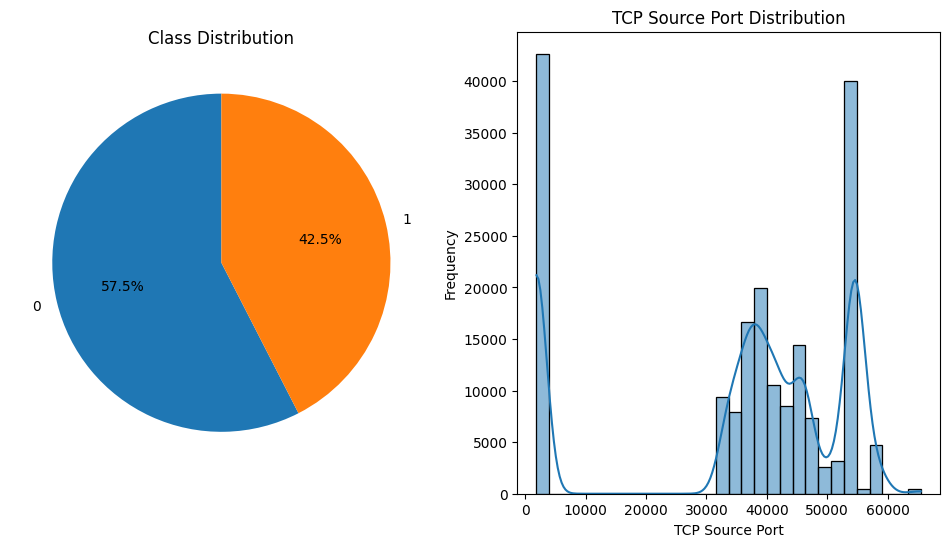

In [ ]:
 #Class Distribution & Feature Analysis
 # Plot class distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
class_counts = y.value_counts()
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution')

# Visualizing a numerical feature distribution
plt.subplot(1, 2, 2)
sns.histplot(df['tcp.srcport'].dropna(), kde=True, bins=30)  # Assuming 'tcp.srcport' is a relevant feature
plt.title('TCP Source Port Distribution')
plt.xlabel('TCP Source Port')
plt.ylabel('Frequency')

plt.show()

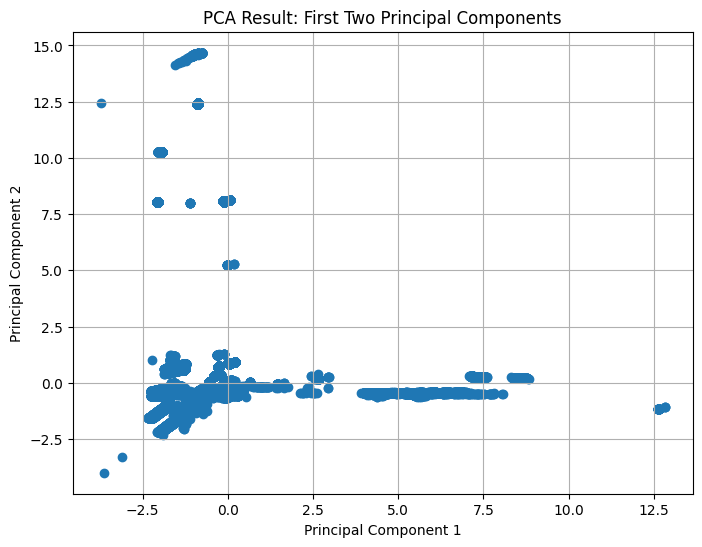

Number of features pre-PCA: 50
Number of features post-PCA: 2


In [ ]:
# Scale numerical features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Plot PCA Results
plt.figure(figsize=(8, 6))
plt.scatter(principal_df['PC1'], principal_df['PC2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Result: First Two Principal Components')
plt.grid(True)
plt.show()

print(f"Number of features pre-PCA: {df.shape[1]}")
print(f"Number of features post-PCA: {principal_df.shape[1]}")

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_scaled, y, test_size=0.3, random_state=42)

# Identify categorical columns for encoding
categorical_cols = df.select_dtypes(include='object').columns

# Apply Frequency Encoding to categorical features
for col in categorical_cols:
    frequency_map = X_train[col].value_counts().to_dict()
    X_train[f"{col}_frequency"] = X_train[col].map(frequency_map)
    X_test[f"{col}_frequency"] = X_test[col].map(frequency_map).fillna(0)
    X_train.drop([col], axis=1, inplace=True)
    X_test.drop([col], axis=1, inplace=True)

# Final scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Final shape of X_train: {X_train.shape}")
print(f"Final shape of X_test: {X_test.shape}")


Final shape of X_train: (132085, 50)
Final shape of X_test: (56609, 50)


In [ ]:
!pip install qiskit-aer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 6.3 MB/s eta 0:00:00


In [ ]:
!pip install qiskit qiskit-machine-learning


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.6/231.6 kB 3.5 MB/s eta 0:00:00


In [ ]:
import qiskit
import qiskit_machine_learning
print("Qiskit version:", qiskit.__version__)
print("Qiskit Machine Learning version:", qiskit_machine_learning.__version__)

Qiskit version: 1.4.2
Qiskit Machine Learning version: 0.8.2


In [ ]:
import torch
import torch.nn as nn
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.primitives import Sampler

# Define Quantum Circuit with feature map and ansatz
n_qubits = 8  # Set number of qubits
feature_map = ZZFeatureMap(n_qubits)
ansatz = RealAmplitudes(n_qubits, reps=1)
qc = QuantumCircuit(n_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

# Use QNN with Sampler backend
sampler = Sampler()
qnn = SamplerQNN(circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, sampler=sampler)

# Connect Quantum Model with PyTorch
quantum_model = TorchConnector(qnn)




<ipython-input-10-f10f32f7796e>:18: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
<ipython-input-10-f10f32f7796e>:19: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, sampler=sampler)


In [ ]:
import torch
import torch.nn as nn
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.primitives import Sampler

# Step 1: Define Quantum Circuit with feature map and ansatz
n_qubits = 8
feature_map = ZZFeatureMap(n_qubits)  # Encodes classical data into quantum states
ansatz = RealAmplitudes(n_qubits, reps=1)  # Quantum trainable layer

# Combine feature map and ansatz into a single circuit
qc = QuantumCircuit(n_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

# Step 2: Define QNN using Qiskit Sampler
sampler = Sampler()
qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    sampler=sampler
)

# Step 3: Convert QNN to PyTorch model using TorchConnector
quantum_model = TorchConnector(qnn)

# Print model summary to check compatibility
print("Quantum CNN Model initialized successfully! ")
print(quantum_model)


<ipython-input-11-24b21d2b1574>:20: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
<ipython-input-11-24b21d2b1574>:21: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(


Quantum CNN Model initialized successfully! 
TorchConnector()


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 817.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 30.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

Epoch 0 | QCNN Loss: 0.7311 Acc: 0.4416
Epoch 0 | CNN Loss: 0.7083 Acc: 0.3695
Epoch 10 | QCNN Loss: 0.3735 Acc: 0.9280
Epoch 10 | CNN Loss: 0.5479 Acc: 0.8916
Epoch 20 | QCNN Loss: 0.1756 Acc: 0.9806
Epoch 20 | CNN Loss: 0.3530 Acc: 0.9884
Epoch 30 | QCNN Loss: 0.0753 Acc: 0.9917
Epoch 30 | CNN Loss: 0.1585 Acc: 0.9895
Epoch 40 | QCNN Loss: 0.0367 Acc: 0.9958
Epoch 40 | CNN Loss: 0.0589 Acc: 0.9890


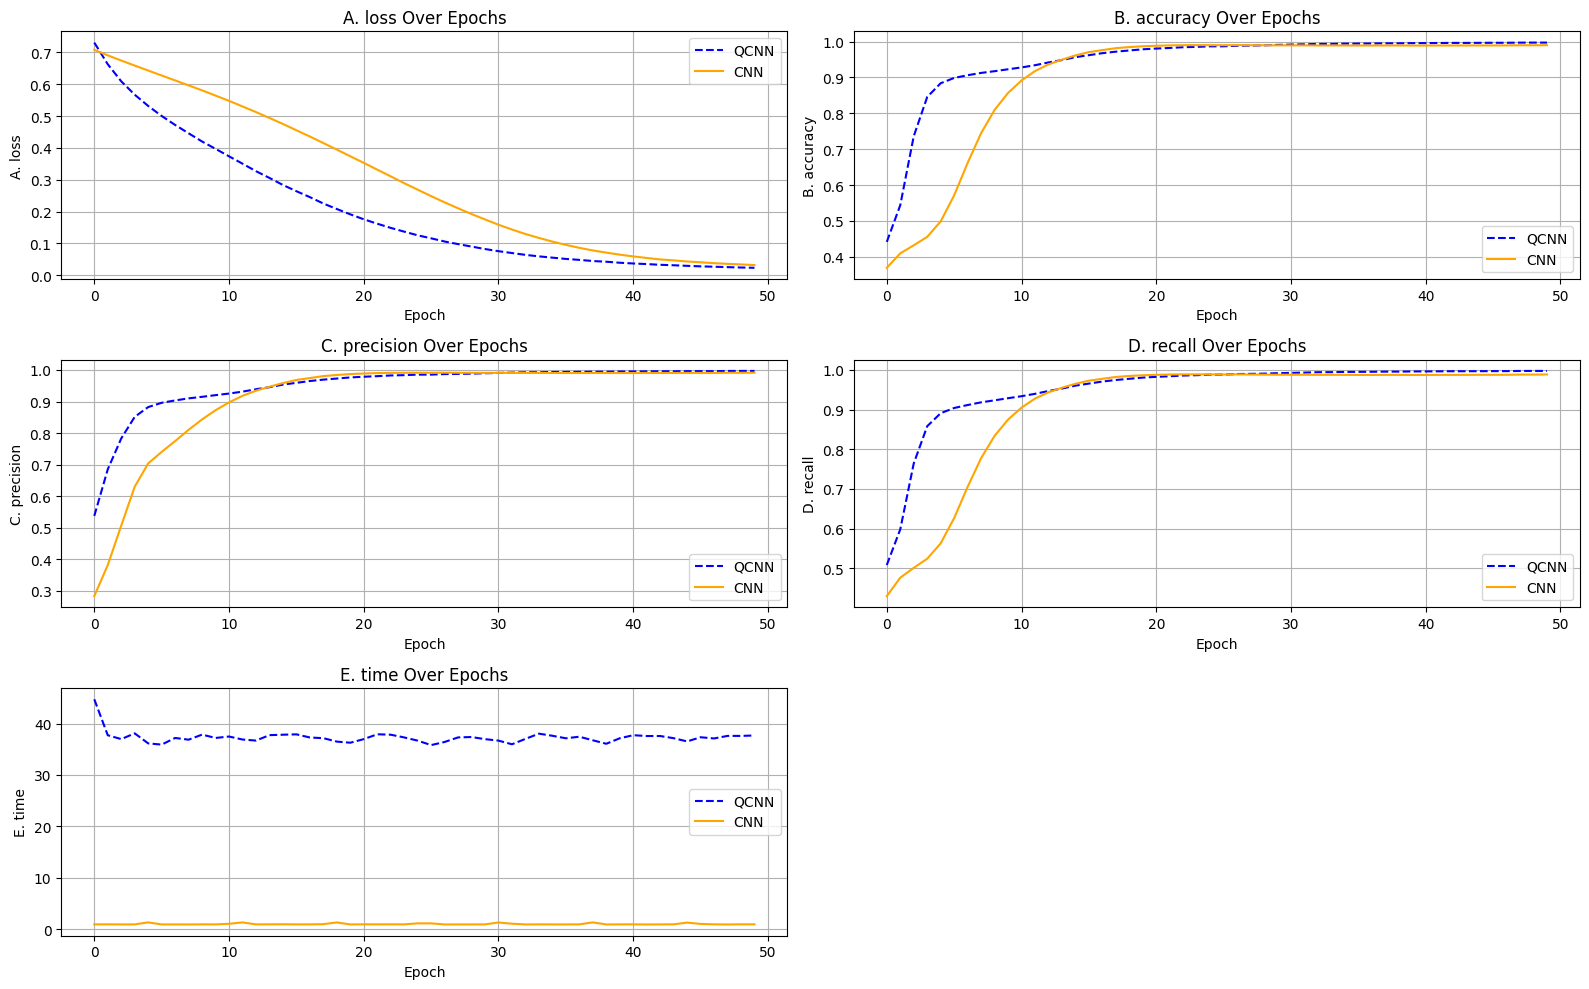

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torchmetrics
from torch.nn import CrossEntropyLoss
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import time
from torch.optim import AdamW

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define CNN model
class ClassicalCNN(nn.Module):
   def __init__(self, input_dim, num_classes):
       super(ClassicalCNN, self).__init__()
       self.model = nn.Sequential(
           nn.Linear(input_dim, 128),
           nn.ReLU(),
          nn.Dropout(0.3),
           nn.Linear(128, 64),
          nn.ReLU(),
           nn.Dropout(0.3),
          nn.Linear(64, num_classes)
      )

   def forward(self, x):
       return self.model(x)

#Define QCnn Model
class QuantumCNN(nn.Module):
   def __init__(self, input_dim, num_classes=2):
        super(QuantumCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(64, 256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(256)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

        self.fc1 = nn.Linear(256, 64)
        self.dropout = nn.Dropout(0.5)
        self.out = nn.Linear(64, num_classes)

   def forward(self, x):
        x = x.unsqueeze(1)

        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.global_avg_pool(x).squeeze(-1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.out(x)  # logits

# Prepare data
n_qubits = 8
num_classes = len(np.unique(y_train))

X_train_qcnn_t = torch.tensor(X_train[:, :n_qubits], dtype=torch.float32).to(device)
X_test_qcnn_t = torch.tensor(X_test[:, :n_qubits], dtype=torch.float32).to(device)
X_train_cnn_t = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_cnn_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train.values, dtype=torch.long).to(device)
y_test_t = torch.tensor(y_test.values, dtype=torch.long).to(device)

# Instantiate models
classical_model = ClassicalCNN(input_dim=X_train.shape[1], num_classes=num_classes).to(device)
quantum_model = QuantumCNN(input_dim=n_qubits, num_classes=num_classes).to(device)

# Optimizer & Loss
optimizer_cnn = Adam(classical_model.parameters(), lr=0.001)
optimizer_qcnn = AdamW(quantum_model.parameters(), lr=0.0005, weight_decay=1e-4)

loss_fn = CrossEntropyLoss()

# Training loop with full metrics
epochs = 50
metrics = {
    'cnn': {'a. loss': [], 'b. accuracy': [], 'c. precision': [], 'd. recall': [], 'e. time': []},
    'qcnn': {'a. loss': [], 'b. accuracy': [], 'c. precision': [], 'd. recall': [], 'e. time': []}
}

for epoch in range(epochs):
    for name, model, optimizer, X_input in zip(['qcnn', 'cnn'], [quantum_model, classical_model], [optimizer_qcnn, optimizer_cnn], [X_train_qcnn_t, X_train_cnn_t]):
        model.train()
        optimizer.zero_grad()

        start_time = time.time()

        output = model(X_input)
        loss = loss_fn(output, y_train_t)
        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=1)
        acc = (pred == y_train_t).float().mean().item()
        prec = torchmetrics.functional.precision(pred, y_train_t, average='macro', num_classes=num_classes, task="multiclass")
        rec = torchmetrics.functional.recall(pred, y_train_t, average='macro', num_classes=num_classes, task="multiclass")

        end_time = time.time()
        elapsed_time = end_time - start_time

        metrics[name]['a. loss'].append(loss.item())
        metrics[name]['b. accuracy'].append(acc)
        metrics[name]['c. precision'].append(prec.item())
        metrics[name]['d. recall'].append(rec.item())
        metrics[name]['e. time'].append(elapsed_time)

        if epoch % 10 == 0:
            print(f"Epoch {epoch} | {name.upper()} Loss: {loss.item():.4f} Acc: {acc:.4f}")

# Plotting Curves
plt.figure(figsize=(16, 10))
for i, metric in enumerate(['a. loss', 'b. accuracy', 'c. precision', 'd. recall', 'e. time']):
    plt.subplot(3, 2, i+1)
    plt.plot(metrics['qcnn'][metric], label='QCNN', linestyle='--', color='blue')
    plt.plot(metrics['cnn'][metric], label='CNN', linestyle='-', color='orange')
    plt.title(f'{metric.capitalize()} Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()




QCNN Performance
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32639
           1       1.00      1.00      1.00     23970

    accuracy                           1.00     56609
   macro avg       1.00      1.00      1.00     56609
weighted avg       1.00      1.00      1.00     56609


CNN Performance
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     32639
           1       1.00      0.98      0.99     23970

    accuracy                           0.99     56609
   macro avg       0.99      0.99      0.99     56609
weighted avg       0.99      0.99      0.99     56609



<Figure size 500x400 with 0 Axes>

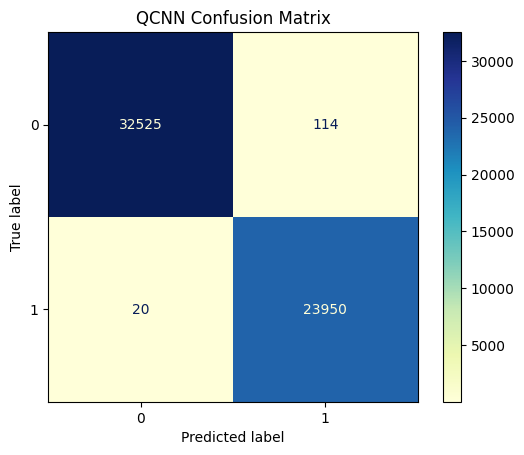

<Figure size 500x400 with 0 Axes>

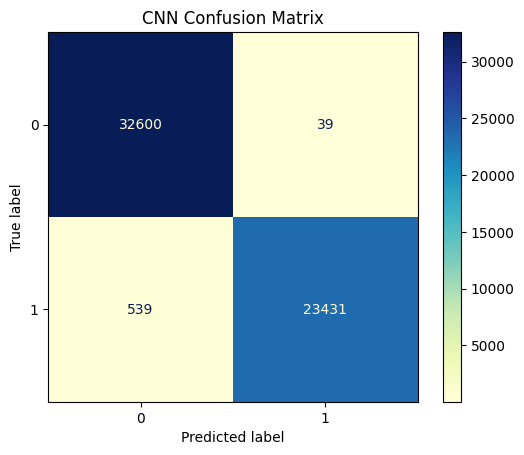

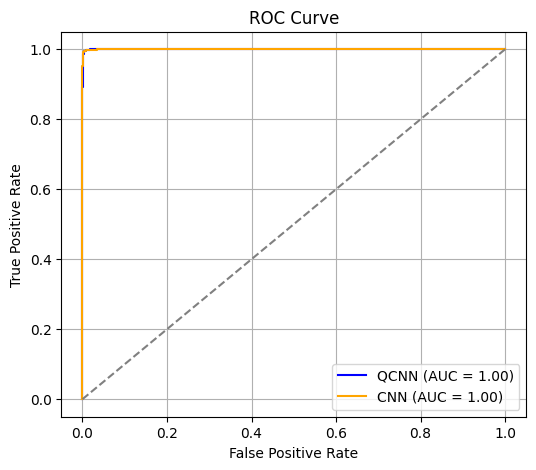

In [ ]:
# Evaluate on test set
y_pred_qcnn = quantum_model(X_test_qcnn_t).detach().cpu().numpy()
y_pred_cnn = classical_model(X_test_cnn_t).detach().cpu().numpy()
y_pred_qcnn_labels = np.argmax(y_pred_qcnn, axis=1)
y_pred_cnn_labels = np.argmax(y_pred_cnn, axis=1)

# Classification Report
for name, y_pred in zip(["QCNN", "CNN"], [y_pred_qcnn_labels, y_pred_cnn_labels]):
    print(f"\n{name} Performance")
    print(classification_report(y_test, y_pred))

# Confusion Matrices
for name, y_pred in zip(["QCNN", "CNN"], [y_pred_qcnn_labels, y_pred_cnn_labels]):
    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot(cmap='YlGnBu')
    plt.title(f'{name} Confusion Matrix')
    plt.grid(False)
    plt.show()

# ROC Curve (Binary classification only)
if num_classes == 2:
    plt.figure(figsize=(6, 5))
    fpr, tpr, _ = roc_curve(y_test, y_pred_qcnn[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"QCNN (AUC = {roc_auc:.2f})", color='blue')

    fpr, tpr, _ = roc_curve(y_test, y_pred_cnn[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"CNN (AUC = {roc_auc:.2f})", color='orange')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
